In [1]:
import path_builder 
import os
from dataset.ss335 import ss335
from common.preprocessing import *
from common.processing import *

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime as dt
from datetime import datetime 
from datetime import date
from tqdm.notebook import tqdm 
from dateutil.relativedelta import relativedelta

In [2]:
global conv ; conv = (1*2.5)*2**-15

In [3]:
axis = 'z'
node_id = 'S613'

april = ss335(axis = axis , node_ID = node_id, month = 'april') 
may   = ss335(axis = axis , node_ID = node_id, month = 'may') 
june  = ss335(axis = axis , node_ID = node_id, month = 'june') 

In [4]:
%%time
apr_ds = april.load()
may_ds = may.load()
jun_ds = june.load()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Wall time: 30.4 s


In [5]:
# split days into train - valid and test set 

train_set = may.split_days(may_ds, 'train')
test_set_pre = april.split_days(apr_ds, 'test')
test_set_post = may.split_days(may_ds, 'test')
valid_set = june.split_days(jun_ds, 'valid')


In [6]:
eg_threshold = threshold_finder(train_input = train_set['z']*conv, valid_input = valid_set['z']*conv, input_dim = 500)

threshold at step 1 is 5e-09
training set composed by 120491 instances
total valid windows is 120491 
ARSNR_PCA = 3.07
threshold at step 2 is 2.5000000000000002e-08
training set composed by 120491 instances
total valid windows is 120491 
ARSNR_PCA = 3.07
threshold at step 3 is 1.2500000000000002e-07
training set composed by 120491 instances
total valid windows is 120397 
ARSNR_PCA = 3.07
threshold at step 4 is 6.25e-07
training set composed by 120491 instances
total valid windows is 50207 
ARSNR_PCA = 5.25
threshold at step 5 is 3.125e-06
training set composed by 120491 instances
total valid windows is 19232 
ARSNR_PCA = 7.59
Valid ARSNR_PCA = 7.59, correct threshold = 3.125e-06, final k is = 36


In [7]:
# Non - Discarded Windows in Training Set,i.e., Structural response to ambient input vibrations cause by vehicles
Train_x = energy_filter(train_set['z']*conv, 500, eg_threshold) 

 - You can generate all the results for Sec V-B, V-C in the paper {link to be added later} by tunning the input configuration of each class.   

# Principal Component Analysis

In [8]:
%%time 
# Find Eigen Vectors of PCA with train set
input_dim = 500 

pca = pca(input_dim= input_dim, domain = 'time', energy_threshold=eg_threshold, CF = 32)
Ex, Vx, k = pca.fit(Train_x)


Wall time: 63.2 ms


In [9]:
# Save the PCA model 
np.save('models/time_model/pca_eigen_values.npy', Vx)

In [10]:
# Test PCA model 

validation_pca  = pca.predict(valid_set, Vx, date(2019, 6, 24), date(2019,6,30))
post_intervention_pca = pca.predict(test_set_post, Vx, date(2019, 5, 10), date(2019,5,20))
pre_intervention_pca = pca.predict(test_set_pre, Vx, date(2019, 4, 17), date(2019,4,23))


  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

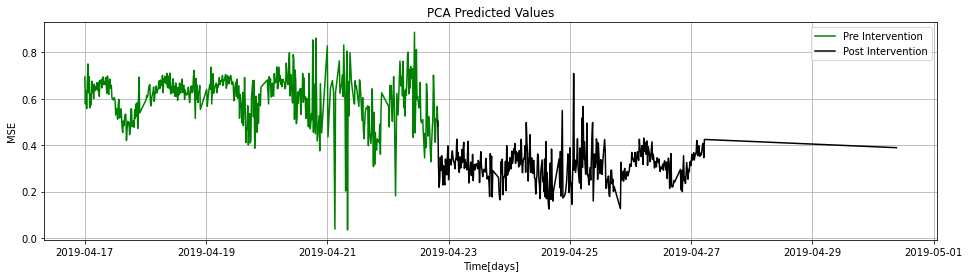

In [11]:
# plot a sample of MSE and Save them

# add the plot from another page 

join_date = post_intervention_pca['date'] - (post_intervention_pca['date'][0] - pre_intervention_pca['date'][-1])
plt.figure(figsize=(16,4))
plt.plot([dt.datetime.utcfromtimestamp(t) for t in pre_intervention_pca['date']], pre_intervention_pca['mse'], color = 'g', 
         label = 'Pre Intervention', linewidth = 1.5)
plt.plot([dt.datetime.utcfromtimestamp(t) for t in join_date], post_intervention_pca['mse'], color = 'k', 
         label = 'Post Intervention', linewidth = 1.5)
plt.grid(axis = 'both')
plt.legend()
plt.title('PCA Predicted Values')
plt.xlabel('Time[days]')
plt.ylabel('MSE')
plt.show()
# Save the data 
df = pd.DataFrame.from_dict(validation_pca)
df.to_csv('results/time/pca/valid.csv', index = False, header = True)


df = pd.DataFrame.from_dict(post_intervention_pca)
df.to_csv('results/time/pca/normal.csv', index = False, header = True)


df = pd.DataFrame.from_dict(pre_intervention_pca)
df.to_csv('results/time/pca/anomaly.csv', index = False, header = True)

# Fully Connected Autoencoder

In [12]:
# Fully Connected Autoencoder Data Prepreation #
import sklearn

X_train = Train_x

# Scale it to have N(0,1)
X_train = sklearn.preprocessing.scale(X_train,
                                   axis = 0, 
                                   with_mean = True,
                                   with_std = True, 
                                   copy = True)

X_train = X_train.T.reshape(X_train.T.shape[0],X_train.T.shape[1]) 
   
print("{} is the Total number of windows after energy filtering".format(X_train.shape[0]))
# nn dimesntion is n0 x 500 
X_train, X_test = train_test_split(X_train,test_size=0.2,random_state=1)
X_train = X_train 
X_test = X_test 
print("{} is the number of windows to train".format(X_train.shape[0]))
print("{} is the number of windows to evaluate the architecture".format(X_test.shape[0]))
print("{} is the dimension of input layer".format(X_train.shape[1]))

19232 is the Total number of windows after energy filtering
15385 is the number of windows to train
3847 is the number of windows to evaluate the architecture
500 is the dimension of input layer


In [13]:
# Train Fully Connected Autoencoder 
nb_epochs = 80
batch_size = 1024
latent_dim = 32
input_dim = X_train.shape[1]


fully_connected = fc_ae(latent_dim = latent_dim, input_dim= input_dim,  
                  batch_size=batch_size, epoch_num=nb_epochs, domain= 'time', energy_threshold=eg_threshold)


fully_connected_model = fully_connected.forward() 
fully_connected_model , fully_connected_history = fully_connected.fit(fully_connected_model, np.array(X_train), np.array(X_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 32)                16032     
                                                                 
 dense_1 (Dense)             (None, 500)               16500     
                                                                 
Total params: 32,532
Trainable params: 32,532
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
16/16 [==============================] - 2s 11ms/step - loss: 136.0596 - mse: 136.0596 - val_loss: 19.4242 - val_mse: 19.4242 - lr: 0.1000
Epoch 2/80
16/16 [==============================] - 0s 4ms/step - loss: 14.9951 - mse: 14.9951 - val_loss: 3.5944 - val_mse: 3.5944 - lr: 0.1000
Epoch 3/80
16/16 [========

Epoch 52/80
16/16 [==============================] - 0s 5ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3933 - val_mse: 0.3933 - lr: 1.0000e-06
Epoch 53/80
16/16 [==============================] - 0s 5ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3933 - val_mse: 0.3933 - lr: 1.0000e-06
Epoch 54/80
16/16 [==============================] - 0s 5ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3933 - val_mse: 0.3933 - lr: 1.0000e-06
Epoch 55/80
16/16 [==============================] - 0s 4ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3933 - val_mse: 0.3933 - lr: 1.0000e-06
Epoch 56/80
16/16 [==============================] - 0s 4ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3933 - val_mse: 0.3933 - lr: 1.0000e-06
Epoch 57/80
16/16 [==============================] - 0s 4ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3933 - val_mse: 0.3933 - lr: 1.0000e-06
Epoch 58/80
16/16 [==============================] - 0s 4ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.3933

Validation accuracy [mse] = 0.39


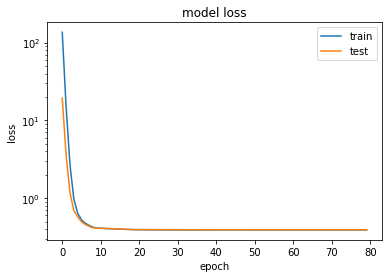

In [14]:
# Plot Train and Evaluation Trend during Fitting the Model 

plt.plot(fully_connected_history['loss'])
plt.plot(fully_connected_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
#plt.ylim(ymax=0.1, ymin = 0)
plt.yscale('log')
print('Validation accuracy [mse] = %.2f' % (fully_connected_history['val_loss'][-1]))

In [15]:
# Save the Fully Connected Autoencoder 

fully_connected_model.save('models/time_model/FC_AE_model.h5')

In [16]:
# Test Fully Connected Autoencoder 

validation_fc  = fully_connected.predict(valid_set, fully_connected_model, date(2019, 6, 24), date(2019,6,30))
post_intervention_fc = fully_connected.predict(test_set_post, fully_connected_model, date(2019, 5, 10), date(2019,5,20))
pre_intervention_fc = fully_connected.predict(test_set_pre, fully_connected_model, date(2019, 4, 17), date(2019,4,23))


  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

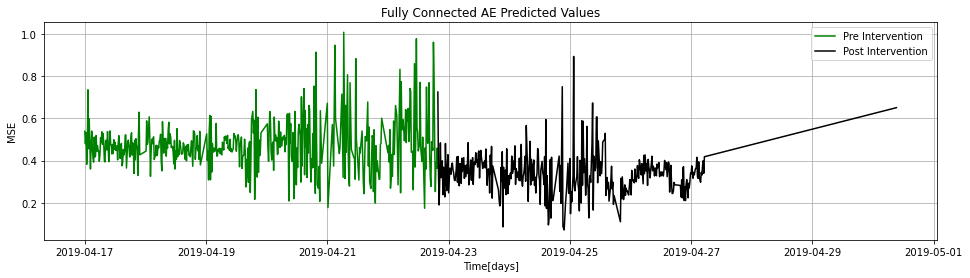

In [17]:
# plot a sample of MSE and Save them

join_date = post_intervention_fc['date'] - (post_intervention_fc['date'][0] - pre_intervention_fc['date'][-1])
plt.figure(figsize=(16,4))
plt.plot([dt.datetime.utcfromtimestamp(t) for t in pre_intervention_fc['date']], pre_intervention_fc['mse'], color = 'g', 
         label = 'Pre Intervention', linewidth = 1.5)
plt.plot([dt.datetime.utcfromtimestamp(t) for t in join_date], post_intervention_fc['mse'], color = 'k', 
         label = 'Post Intervention', linewidth = 1.5)
plt.grid(axis = 'both')
plt.legend()
plt.title('Fully Connected AE Predicted Values')
plt.xlabel('Time[days]')
plt.ylabel('MSE')
plt.show()
# Save the data 
df = pd.DataFrame.from_dict(validation_fc)
df.to_csv('results/time/fc_ae/valid.csv', index = False, header = True)


df = pd.DataFrame.from_dict(post_intervention_fc)
df.to_csv('results/time/fc_ae/normal.csv', index = False, header = True)


df = pd.DataFrame.from_dict(pre_intervention_fc)
df.to_csv('results/time/fc_ae/anomaly.csv', index = False, header = True)

# 1D - Convolutional Neural Network Autoencoder

In [18]:
X_train = Train_x
X_train = sklearn.preprocessing.scale(X_train, 
                                    axis = 0, 
                                    with_mean = True, 
                                    with_std = True, 
                                    copy = True)
X_train = X_train.T.reshape(X_train.T.shape[0], X_train.T.shape[1], 1)
Xtrain, Xtest = train_test_split(X_train, test_size = 0.2, random_state = 1)
X_train = Xtrain
X_test = Xtest
print("{} is the number of windows to train".format(X_train.shape[0]))
print("{} is the number of windows to evaluate the architecture".format(X_test.shape[0]))
print("{} is the dimension of input layer".format(X_train.shape[1]))

15385 is the number of windows to train
3847 is the number of windows to evaluate the architecture
500 is the dimension of input layer


In [19]:
# Train Fully Connected Autoencoder 
from tensorflow.keras.optimizers import SGD,Adam
nb_epochs = 80
batch_size = 512
input_dim = X_train.shape[1]


cnn = cnn_ae( input_dim= input_dim,  
                  batch_size=batch_size, epoch_num=nb_epochs, domain= 'time', energy_threshold=eg_threshold)


cnn_model ,  cnn_history = cnn.forward_fit(X_train, X_test) 
#cnn_model , cnn_history = cnn.fit(cnn_model, np.array(X_train), np.array(X_test))

(None, 250, 16)
(None, 250, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 500, 16)           64        
                                                                 
 batch_normalization (BatchN  (None, 500, 16)          64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 1)            113       
                                                                 
 batch_normalization_1 (Batc

Epoch 38/80
31/31 [==============================] - 1s 20ms/step - loss: 0.1927 - mse: 0.1927 - val_loss: 0.1957 - val_mse: 0.1957 - lr: 1.0000e-04
Epoch 39/80
31/31 [==============================] - 1s 20ms/step - loss: 0.1926 - mse: 0.1926 - val_loss: 0.1955 - val_mse: 0.1955 - lr: 1.0000e-04
Epoch 40/80
31/31 [==============================] - 1s 19ms/step - loss: 0.1926 - mse: 0.1926 - val_loss: 0.1953 - val_mse: 0.1953 - lr: 1.0000e-05
Epoch 41/80
31/31 [==============================] - 1s 20ms/step - loss: 0.1926 - mse: 0.1926 - val_loss: 0.1952 - val_mse: 0.1952 - lr: 1.0000e-05
Epoch 42/80
31/31 [==============================] - 1s 20ms/step - loss: 0.1926 - mse: 0.1926 - val_loss: 0.1952 - val_mse: 0.1952 - lr: 1.0000e-05
Epoch 43/80
31/31 [==============================] - 1s 19ms/step - loss: 0.1926 - mse: 0.1926 - val_loss: 0.1951 - val_mse: 0.1951 - lr: 1.0000e-05
Epoch 44/80
31/31 [==============================] - 1s 19ms/step - loss: 0.1926 - mse: 0.1926 - val_loss:

Validation accuracy [mse] = 0.20


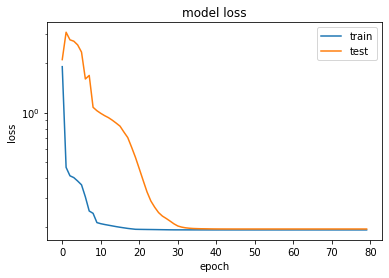

In [20]:
# Plot Train and Evaluation Trend during Fitting the Model 

plt.plot(cnn_history['loss'])
plt.plot(cnn_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.yscale('log')
print('Validation accuracy [mse] = %.2f' % (cnn_history['val_loss'][-1]))

In [21]:
# Save the Model

cnn_model.save('models/time_model/CNN_AE_model.h5')

In [24]:
# Test the Model 

validation_cnn  = cnn.predict(valid_set, cnn_model, date(2019, 6, 24), date(2019,6,30))
post_intervention_cnn = cnn.predict(test_set_post, cnn_model, date(2019, 5, 10), date(2019,5,20))
pre_intervention_cnn = cnn.predict(test_set_pre, cnn_model, date(2019, 4, 17), date(2019,4,23))


  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

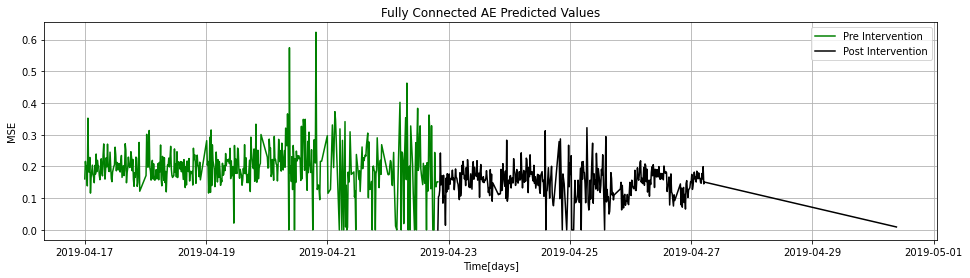

In [25]:
# plot a sample of MSE and Save them

join_date = post_intervention_cnn['date'] - (post_intervention_cnn['date'][0] - pre_intervention_cnn['date'][-1])
plt.figure(figsize=(16,4))
plt.plot([dt.datetime.utcfromtimestamp(t) for t in pre_intervention_cnn['date']], pre_intervention_cnn['mse'], color = 'g', 
         label = 'Pre Intervention', linewidth = 1.5)
plt.plot([dt.datetime.utcfromtimestamp(t) for t in join_date], post_intervention_cnn['mse'], color = 'k', 
         label = 'Post Intervention', linewidth = 1.5)
plt.grid(axis = 'both')
plt.legend()
plt.title('Fully Connected AE Predicted Values')
plt.xlabel('Time[days]')
plt.ylabel('MSE')
plt.show()
# Save the data 
df = pd.DataFrame.from_dict(validation_cnn)
df.to_csv('results/time/cnn_ae/valid.csv', index = False, header = True)


df = pd.DataFrame.from_dict(post_intervention_cnn)
df.to_csv('results/time/cnn_ae/normal.csv', index = False, header = True)


df = pd.DataFrame.from_dict(pre_intervention_cnn)
df.to_csv('results/time/cnn_ae/anomaly.csv', index = False, header = True)

# End of the Script 